 First, we set up a grid. We propose a 1000m x 1000m grid with nodes separated by 10 m in both directions. We therefore need 101 nodes in each direction We will work in the SI to simplify the code and not make silly mistakes.

In [7]:
Nx=101;
Ny=101;

To solve the eikonal equation we need to model the wave speed. A simple model is  $c=c_{air}+\vec{v_{wind}}.\vec{n}$. Now we set $c_{air}=340 m/s$  and $v_{wind}=(10,0)m/s$. In the X direction, the wavefront normal is $\vec{n}=(1,0)$ and consequently $c_x=350 m/s$. In the Y direction, the wavefront normal is $\vec{n}=(0,1)$ and consequently $c_y=340 m/s$. In diagonal $\vec{n}=\frac{(1,1)}{\sqrt{2}}$ and $c_d=(340+\frac{10}{\sqrt{2}}) m/s= 347,0710678 m/s$

 We obtain the gradient of the flight time from the Eikonal equation.  ${\nabla{T}(x,y)}^2=\frac{1}{c(x,y)^2} \Rightarrow |\nabla{T}(x,y)|=|\frac{1}{c(x,y)}| $ . This leads to a system of partial differential equations. However, in certain directions where the speed is constant, we know the analytical result which is simply $\nabla{T}=1/c$.

We can analytically know the result for a given source and a given distance in certain constant speed scenarios, so it serves as a "benchmark" for the methods to be applied.

# FastMarching package

ref:https://docs.juliahub.com/General/FastMarching/stable/autodocs/

### Msfm function of FastMarching 

We see that flight time is obtained using the FastMarching package already implemented in Julia. First, we observe the result for a single constant speed in all directions that matches with c_air=340m/s.  We set $(x_i,y_i)=(0,0)m ; (x_f, y_f)=(1000,1000)m$. The distance travelled is $d=\sqrt{1000m^2+1000m^2}=1414,21m$

In [8]:
using FastMarching
c_air=340.0
c_air_matrix= fill(c_air, (Nx, Ny))
SourcePoint = [1.,1.]  # Starting point
T = FastMarching.msfm(c_air_matrix, SourcePoint, true, true)
# We can obtain the flight time athe receiver [100m,100m]
travel_time = 10*T[101, 101];
analytic_travel_time=sqrt(1000^2+1000^2)/c_air;

println("The travel time obtained by FastMarching is $travel_time")
println("The travel time obtained analytically is $analytic_travel_time")

The travel time obtained by FastMarching is 4.160841479305828
The travel time obtained analytically is 4.159451654038515


Now we must define the wave speed map at every node point based on the expression $c=c_{air}+\vec{v_{wind}}.\vec{n}$; with $\vec{n}$ variable depending on the point. 

In [9]:
using LinearAlgebra
function map_speed(c_air::Float64,v_wind::Array{Float64,1},SourcePoint::Array{Float64,1},Nx::Int64, Ny::Int64)
    c=fill(c_air, (Nx, Ny));
    n = zeros(Float64,Nx, Ny, 2);
    for i in 1:Nx, j in 1:Ny
        vector=[float(i),float(j)]-SourcePoint;
        n[i,j,:]=vector/norm(vector);
        c[i,j]=c_air+dot(v_wind,n[i,j,:]);
        if [float(i),float(j)]==SourcePoint 
            #Initial condition
            c[i,j]=c_air
            n[i,j,:]=[0.,0.]
        end  
    end
    return c
end

map_speed (generic function with 1 method)

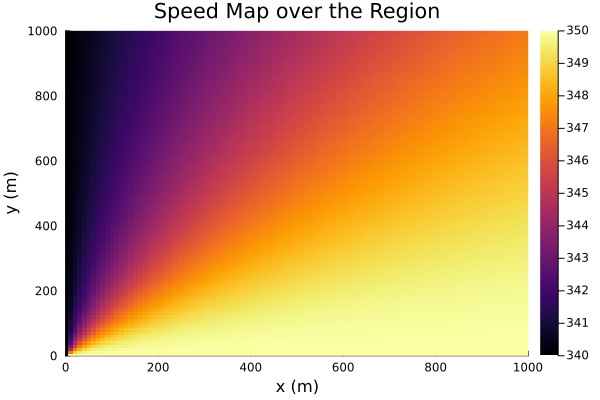

In [10]:
v_wind=[10.,0.];
#Even though the source corresponds to nodes, it is simpler to define it as a vector of floating point components.
SourcePoint=[1.,1.];
c=map_speed(c_air,v_wind,SourcePoint,Nx,Ny);
#Plotting
using Plots
x = range(0, stop=1000, length=Nx)
y = range(0, stop=1000, length=Ny)
Plots.heatmap(x,y,transpose(c), xlims=(0,1000), ylims=(0,1000), title="Speed Map over the Region", xlabel="x (m)", ylabel="y (m)")

In [17]:
@time begin
T = FastMarching.msfm(c, SourcePoint, true, true)
# We can obtain the flight time at the receiver 
println("Along the X axis:")
travel_time_X = 10*T[101, 1];
analytic_travel_time_X=1000/350.
end
println("The travel time obtained by FastMarching is $travel_time_X")
println("The travel time obtained analytically is $analytic_travel_time_X")

println("Along the Y axis:")
travel_time_Y = 10*T[1, 101];
analytic_travel_time_Y=1000/340.
println("The travel time obtained by FastMarching is $travel_time_Y")
println("The travel time obtained analytically is $analytic_travel_time_Y")


Along the X axis:
  0.008549 seconds (34 allocations: 321.820 KiB)
The travel time obtained by FastMarching is 2.857142857142703
The travel time obtained analytically is 2.857142857142857
Along the Y axis:
The travel time obtained by FastMarching is 2.9411472965032637
The travel time obtained analytically is 2.9411764705882355


In the Y direction, a similar but different result is obtained. It may not follow a straight path in the Y direction. Makes sense.

# Gadfly package

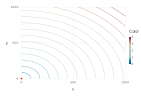

In [12]:
using Gadfly
x = range(0, stop=1000, length=Nx)
y = range(0, stop=1000, length=Ny)
p=Gadfly.plot(x=x[:],y=y[:],z=10*T, Geom.contour,Coord.Cartesian(xmin=0, xmax=1000, ymin=0, ymax=1000))
Gadfly.push!(p, layer(x=[SourcePoint[1]], y=[SourcePoint[2]], Geom.point, Theme(default_color="red")))

# Fast Sweeping method of Eikonal package

Ref: https://github.com/triscale-innov/Eikonal.jl/blob/main/docs/ripple-tank/ripple-tank.md

In [19]:
@time begin
using Eikonal
# Define the slowness field sigma in the Eikonal context
sigma = 1.0 ./ c;
fs = FastSweeping(sigma);
# Source point. We must use integers here
source_point = (1, 1);
# Initialize the wavefront arrival time at the source point
init!(fs, source_point);
sweep!(fs, verbose=true);
travel_time_FSM=fs.t[1:Nx,1:Ny];
travel_time_FSM_x=10*travel_time_FSM[101,1];
end
#The time matrix fs.t is initialized with an additional dimension in each direction to handle boundary conditions.
#This is done to avoid out-of-range index problems during the sweeping calculation. 
#The additional values in fs.t represent the travel times in the “ghost cells” outside the real calculation domain.
#Therefore, fs.t is a matrix of dimension (Nx+1) x (Ny+1).



iter 1, sweep 1: change = 0.0
iter 1, sweep 2: change = Inf
iter 1, sweep 3: change = 0.0
iter 1, sweep 4: change = Inf
iter 2, sweep 1: change = Inf
iter 2, sweep 2: change = 1.9347269041551542e-5
iter 2, sweep 3: change = 0.0
iter 2, sweep 4: change = 0.0
iter 3, sweep 1: change = 2.997295038024945e-6
iter 3, sweep 2: change = 4.694675605996832e-7
iter 3, sweep 3: change = 0.0
iter 3, sweep 4: change = 0.0
iter 4, sweep 1: change = 2.847539596148889e-8
iter 4, sweep 2: change = 0.0
iter 4, sweep 3: change = 0.0
iter 4, sweep 4: change = 0.0
  0.007711 seconds (710 allocations: 285.195 KiB)


2.8579831932773123

The travel time obtained by FastSweeping along the X axis is 2.8579831932773123
The travel time obtained analytically along the X axis is 2.857142857142857


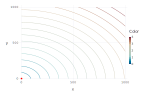

In [8]:
travel_time_FSM=fs.t[1:Nx,1:Ny];
travel_time_FSM_x=10*travel_time_FSM[101,1];
println("The travel time obtained by FastSweeping along the X axis is $travel_time_FSM_x")
println("The travel time obtained analytically along the X axis is $analytic_travel_time_X")
using Gadfly
x = range(0, stop=1000, length=Nx)
y = range(0, stop=1000, length=Ny)
p2=Gadfly.plot(x=x[:],y=y[:],z=10*travel_time_FSM, Geom.contour,Coord.Cartesian(xmin=0, xmax=1000, ymin=0, ymax=1000))
Gadfly.push!(p2, layer(x=[SourcePoint[1]], y=[SourcePoint[2]], Geom.point, Theme(default_color="red")))